In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import binom_test
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
from statsmodels.stats.proportion import proportion_confint

%matplotlib inline
#придется читать с флешки. я out of memory
history_directory = 'F:\\history\\'
trends_directory = 'F:\\trends_out_dublers_new\\'
colnames = ['<TIME>', '<VOLUME>', '<PRICE>']

sorted_directory_list = ['trends_outofdublers_TPV_615.csv', 
                         'trends_outofdublers_TPV_915.csv', 'trends_outofdublers_TPV_1215.csv', 
                         'trends_outofdublers_TPV_316.csv', 'trends_outofdublers_TPV_616.csv', 
                         'trends_outofdublers_TPV_916.csv', 'trends_outofdublers_TPV_1216.csv', 
                         'trends_outofdublers_TPV_317.csv', 'trends_outofdublers_TPV_617.csv', 
                         'trends_outofdublers_TPV_917.csv', 'trends_outofdublers_TPV_1217.csv', 
                         'trends_outofdublers_TPV_318.csv', 'trends_outofdublers_TPV_618.csv', 
                         'trends_outofdublers_TPV_918.csv', 'trends_outofdublers_TPV_1218.csv']

price = lambda x : y_column[x] #  функция цены акции от номера тика

def evaluete_1d_list(forecast_window_data, direction):
    
        '''определяет оценку одномерного массива forecast_window_data
           при заданном направлении direction паттерна. 
           возвращает 1, если цена продолжает движение,
           -1 если возвращается, 0 если остается без движения'''
        
        if direction == 1: #сопротивление
            Ay = max(forecast_window_data)
            By = min(forecast_window_data)
            Ax = forecast_window_data.index(Ay)
            Bx = forecast_window_data.index(By)
            if Ay > abs(By):
                return 0
            if Ay < abs(By):
                return 1
            else:
                if Ay == By == 0:
                    return -1
                if Ax < Bx:
                    return 0
                else:
                    return 1
        else: # поддержка
            Ay = min(forecast_window_data)
            By = max(forecast_window_data)
            Ax = forecast_window_data.index(Ay)
            Bx = forecast_window_data.index(By)
            if abs(Ay) > By:
                return 0
            if abs(Ay) < By:
                return 1
            else:
                if Ay == By == 0:
                    return -1
                if Ax < Bx:
                    return 0
                else:
                    return 1 
                
def calc_result_of_deal(forecast_window_data, direction, up, down, enter_point_price):
    
        '''рассчитывает прибыль/убыток при заданном направлении direction паттерна 
           (шортим, если direction = 1 и покупаем на direction = 2)
           от реализации сделки момент, при которой точка входа осуществлялась 
           в момент, когда цена контракта составляла enter_point_price, а выход 
           из позиции осуществлялся по преодолению изменением цены верхней границы  
           up, либо нижней границы down в одномерном массиве forecast_window_data, 
           содержащем кусок истории цен.'''
        if max(forecast_window_data) < up and min(forecast_window_data) > down:
            return(0) # не хватило окна, либо контракт закончил свое существование.
        position = 0
        max_position = len(forecast_window_data)
        if direction == 1: #сопротивление
            for _price in forecast_window_data:
                position += 1
                if position > max_position:
                    return(0) # контракт закончил свое существование.
                if _price >= up:                       
                    return(enter_point_price - up)
                if _price <= down:
                    return(enter_point_price - down)                              
        else: # поддержка
            for _price in forecast_window_data:
                position += 1
                if position > max_position:
                    return(0) # контракт закончил свое существование.
                if _price <= down:                       
                    return(down - enter_point_price)
                if _price >= up:
                    return(up - enter_point_price)                    
           

## Иллюстрация к функции оценки паттерна (evaluete_1d_list).
![](image)
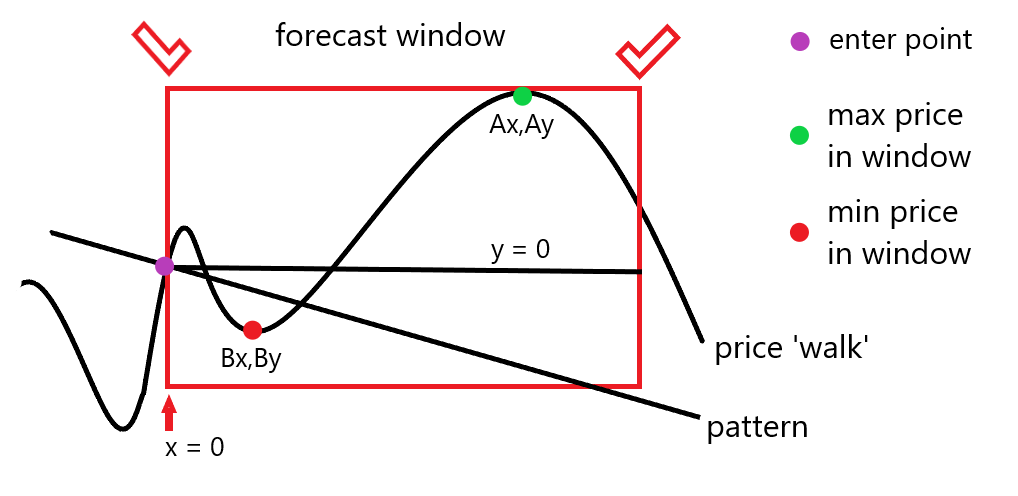

Пройдем по истории (время жизни контракта - 3 месяца, в каждом дне около 100 000 тиков) и соберем списки с оценками для кажого контракта ([1, 1, 0, 0, 1,...] (игнорируя случаи, где Ay = By = 0)). 

Начнем с фиксированного окна в будущее = 50 тиков.


In [2]:
grade_list = []
future_window = 50
for trend_file in sorted_directory_list:
    trend_data = pd.read_csv(trends_directory + trend_file, header= 0, error_bad_lines=False)
    cols = trend_data.columns
    type_of_line = trend_data[cols[0]]# 1 - сопротивление, 2 - поддержка
    start = trend_data[cols[1]]
    end = trend_data[cols[2]]
    corresponding_tick_file_name = history_directory + 'pureSBER' + \
                                   trend_file.split('trends_outofdublers_TPV_')[1]
    tick_data = pd.read_csv(corresponding_tick_file_name, sep = ',',  \
                            names=colnames, header = 0)

    y_column = tick_data['<PRICE>']
    y_column = list(y_column)
    ticks_total = len(y_column) - 1 
    x_list = list(range(len(y_column)))
       
    grade_list_one_contract  = []  
    for i, j, direction in zip(start, end, type_of_line):
        start_price = price(j)
        future_window_end = j + future_window
        if future_window_end > ticks_total:
            future_window_end = ticks_total
        y_list = [(x - start_price) for x in y_column[j:future_window_end]]
        pattern_grade = evaluete_1d_list(y_list, direction)        
        grade_list_one_contract.append(pattern_grade)        
    # удалим примеры, где цена осталась без единого изменения во всем окне    
    grade_list_one_contract = list(filter(lambda a: a != -1, grade_list_one_contract))
    grade_list.append(grade_list_one_contract)    

Посмотрим на среднее значение списка оценок паттернов в каждом контракте (100% случаев возврата цены под паттерн соответствуют среднему = 1, если 50/50, то среднее = 0.5, 100% выход цены за пределы паттерна соответствует среднему = 0)

In [3]:
for name, x in zip(sorted_directory_list, grade_list):
    print('средняя оценка в контракте № {}'.format(name.split('TPV')[1][1:-4]) + ' = {0:.3g}'.format(np.mean(x)) + '     количество сигналов = {}'.format(len(x)))

print()
amount_of_signals = sum([len(x) for x in grade_list])
mean_disproportion = np.mean([np.mean(x) for x in grade_list])
print('средняя оценка за все время = {0:.3g}'.format(mean_disproportion), 'всего сигналов за 615-1218 = {}'.format(amount_of_signals))

средняя оценка в контракте № 615 = 0.754     количество сигналов = 1849
средняя оценка в контракте № 915 = 0.8     количество сигналов = 1317
средняя оценка в контракте № 1215 = 0.731     количество сигналов = 1390
средняя оценка в контракте № 316 = 0.726     количество сигналов = 1261
средняя оценка в контракте № 616 = 0.713     количество сигналов = 1393
средняя оценка в контракте № 916 = 0.729     количество сигналов = 926
средняя оценка в контракте № 1216 = 0.658     количество сигналов = 890
средняя оценка в контракте № 317 = 0.612     количество сигналов = 1016
средняя оценка в контракте № 617 = 0.633     количество сигналов = 1345
средняя оценка в контракте № 917 = 0.625     количество сигналов = 1293
средняя оценка в контракте № 1217 = 0.605     количество сигналов = 1447
средняя оценка в контракте № 318 = 0.591     количество сигналов = 1370
средняя оценка в контракте № 618 = 0.589     количество сигналов = 1913
средняя оценка в контракте № 918 = 0.626     количество сигналов 

Дли корректности посчитаем уровень значимости такого отклонения, используя биномиальный тест с честной двусторонней гипотезой:

In [4]:
for name, x in zip(sorted_directory_list, grade_list):
    print('p_value для контракта № {}'.format(name.split('TPV')[1][1:-4]) + ' = ' + str(binom_test(sum(x), len(x), p=0.5, alternative='two-sided')))

# При данных уровнях значимости поправка на множественную проверку гипотез не сыграет против.

p_value для контракта № 615 = 1.8609369991533316e-110
p_value для контракта № 915 = 9.594178207386795e-112
p_value для контракта № 1215 = 9.61452865517971e-69
p_value для контракта № 316 = 4.631613921374934e-60
p_value для контракта № 616 = 1.9577081369341208e-58
p_value для контракта № 916 = 1.5892304034063206e-45
p_value для контракта № 1216 = 2.1104185970033628e-21
p_value для контракта № 317 = 8.602213876348327e-13
p_value для контракта № 617 = 9.220210960260549e-23
p_value для контракта № 917 = 2.2251122173628913e-19
p_value для контракта № 1217 = 1.6133891505217577e-15
p_value для контракта № 318 = 2.2146931967517518e-11
p_value для контракта № 618 = 6.494963937702641e-15
p_value для контракта № 918 = 1.0829320086056925e-28
p_value для контракта № 1218 = 5.0227314605722835e-40


Грубо оценим доверительный интервал отклонения цены от точки входа. 
В отличие от винеровского процесса у нас price = k * sqrt(t) где k != 1 
(но в среднем можем принять k ~ 1 для коротких промежутков времени - я считал) 
![](image)
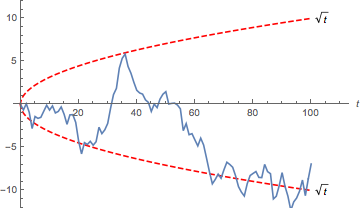
Значит для фиксированного окна в будущее можем принять
95% доверительный интервал отклонения цены = (-2 * sqrt(time), +2 * sqrt(time)). Если учесть, что в >99% случаев цена 
не стоит на месте и шаг цены = 1р, то для окна = 50 тиков получаем отклонение в рамках [от -14 до -1, от 1 до +14] пунктов
фьючерсного контракта SBRF. Если принять объем ставки = 1 контракту, 

то средняя доходность за время обращения 1 контракта без учета комиссии = 16,8% * price_move * 22111 сигналов / 15 контрактов. 95% доверительный интервал этой величины = [248, 3464] (в рублях)

Давайте проверим рассуждения просто через бэктест на всей доступной истории для 14 вариантов границ выхода из позиции. Примем объем сделки = 1 контракт. Войдя в позицию, установим sl = tp в диапазоне от 1 до 14 пунктов, (можно поискать оптимальную комбинацию вложенным циклом, сделать хитмэп, но это очень долго считать) выйдем только по достижении ценой данных границ.

In [61]:
portfolio_result_all = []
future_window = 10000# возьмем с запасом, чтобы наверняка выйти из позиции
boarder_list = list(range(1, 15))
for boarder in boarder_list:   
    deal_list = [] 
    for trend_file in sorted_directory_list:
        trend_data = pd.read_csv(trends_directory + trend_file, header= 0, error_bad_lines=False)
        cols = trend_data.columns
        type_of_line = trend_data[cols[0]]# 1 - сопротивление, 2 - поддержка
        start = trend_data[cols[1]]
        end = trend_data[cols[2]]
        corresponding_tick_file_name = history_directory + 'pureSBER' + \
                                       trend_file.split('trends_outofdublers_TPV_')[1]
        tick_data = pd.read_csv(corresponding_tick_file_name, sep = ',',  \
                                names=colnames, header = 0)
        y_column = tick_data['<PRICE>']
        y_column = list(y_column)
        ticks_total = len(y_column) - 1 
        x_list = list(range(len(y_column)))

#         grade_list_one_contract  = []  
        for i, j, direction in zip(start, end, type_of_line):
            start_price = price(j)
            future_window_end = j + future_window
            if future_window_end > ticks_total:
                future_window_end = ticks_total
            y_list = [(x - start_price) for x in y_column[j:future_window_end]]
            up = boarder
            down = -boarder
            deal_grade = calc_result_of_deal(y_list, direction, up, down, 0)   
            deal_list.append(deal_grade)        
    # собираем список из списков returns    
    portfolio_result_all.append(deal_list)       

In [14]:
print('без комиссии')
risk = 0
for i in portfolio_result_all:
    risk += 1    
    print('risk = {}'.format(risk) + '    sharp_ratio = {}'.format(np.mean(np.cumsum(i))/np.std(np.cumsum(i))) + '    средний профит за 3 месяца = {0:.5g}'.format(np.sum(i)/15))

без комиссии
risk = 1    sharp_ratio = 2.4725564347107425    средний профит за 3 месяца = 456.07
risk = 2    sharp_ratio = 2.1217439485747893    средний профит за 3 месяца = 1136.9
risk = 3    sharp_ratio = 1.810398462046496    средний профит за 3 месяца = 1415.4
risk = 4    sharp_ratio = 1.6140245365037165    средний профит за 3 месяца = 1346.4
risk = 5    sharp_ratio = 1.5199967159013983    средний профит за 3 месяца = 1145.7
risk = 6    sharp_ratio = 1.5008514839864127    средний профит за 3 месяца = 949.2
risk = 7    sharp_ratio = 1.5854948430614142    средний профит за 3 месяца = 720.07
risk = 8    sharp_ratio = 1.7285666465930658    средний профит за 3 месяца = 574.4
risk = 9    sharp_ratio = 1.849630250261867    средний профит за 3 месяца = 468.6
risk = 10    sharp_ratio = 2.0765881137957107    средний профит за 3 месяца = 372.67
risk = 11    sharp_ratio = 2.06457007205427    средний профит за 3 месяца = 219.27
risk = 12    sharp_ratio = 1.5200219389405785    средний профит за 3

При работе с такими короткими движениями уровень комиссии имеет большое значение. Надо найти комиссию, начиная с которой, стратегия перестанет работать

In [63]:
volume_of_operations = [] 
for trend_file in sorted_directory_list:
    trend_data = pd.read_csv(trends_directory + trend_file, header= 0, error_bad_lines=False)
    cols = trend_data.columns
    type_of_line = trend_data[cols[0]]# 1 - сопротивление, 2 - поддержка
    start = trend_data[cols[1]]
    end = trend_data[cols[2]]
    corresponding_tick_file_name = history_directory + 'pureSBER' + \
                                   trend_file.split('trends_outofdublers_TPV_')[1]
    tick_data = pd.read_csv(corresponding_tick_file_name, sep = ',',  \
                            names=colnames, header = 0)
    y_column = tick_data['<PRICE>']
    y_column = list(y_column)
    ticks_total = len(y_column) - 1 
    x_list = list(range(len(y_column)))

    
    for i, j, direction in zip(start, end, type_of_line):
        start_price = price(j)
        volume_of_operations.append(2*start_price)               

In [64]:
comision_coeff_list = [x/500000 for x in range (0, 14, 1)]
result_sharp = []
result_mean_profit_per_contract = []
for comision_coeff in comision_coeff_list:
    risk = 0
    comission_payment = [i * comision_coeff for i in volume_of_operations]
    _sharp = []
    _profit_per_contract = []
    result_risk = []
    for i in zip(portfolio_result_all):
        risk += 1
        result_risk += [risk]
        _profit_per_contract += [(np.sum(i) - np.sum(comission_payment))/15]
        _sharp += [np.mean(np.cumsum(i) - np.cumsum(comission_payment))/np.std(np.cumsum(i))]
    result_sharp += [_sharp]   
    result_mean_profit_per_contract += [_profit_per_contract]  

In [8]:
def plot_3d(risk, data, the_title, hor_rot, vert_rot):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 7

    comission_coeff_list_percent = [x/5000 for x in range (0, 14, 1)]
    risk, comission = np.meshgrid(risk, comission_coeff_list_percent)
    data = np.array(data)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.view_init(azim=hor_rot, elev=vert_rot)
    surf = ax.plot_surface(risk, comission, data, cmap=cm.seismic)
    ax.set_xlabel('risk', fontsize = 12)
    ax.set_ylabel('commission', fontsize = 12)

    #ax.set_zlabel('sharp ratio')
    #Customize the z axis.
    #ax.set_zlim(-100000, 100000.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    #Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title(the_title)
    plt.show()                              

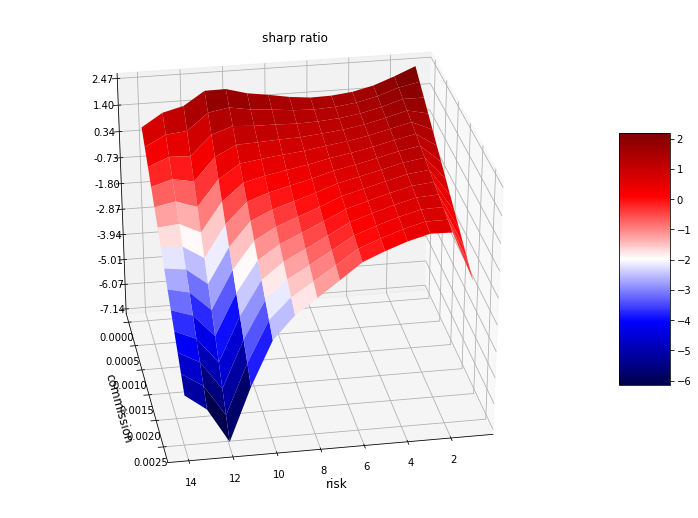

In [66]:
plot_3d(result_risk, result_sharp, 'sharp ratio', 80, 30)

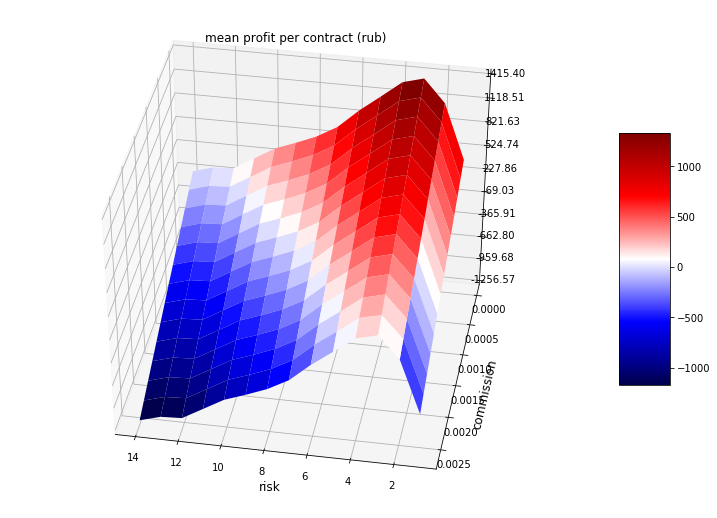

In [67]:
plot_3d(result_risk, result_mean_profit_per_contract, 'mean profit per contract (rub)', 100, 40)

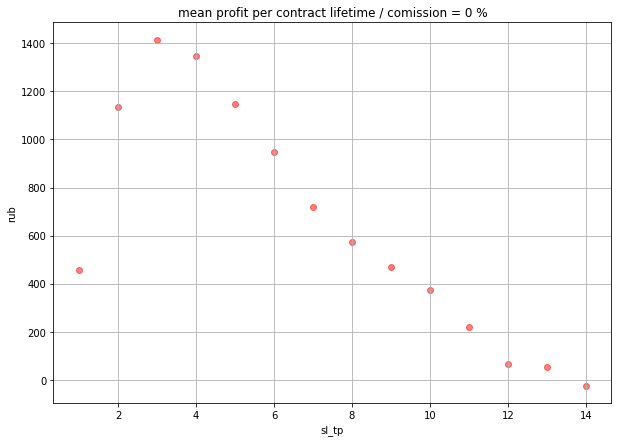

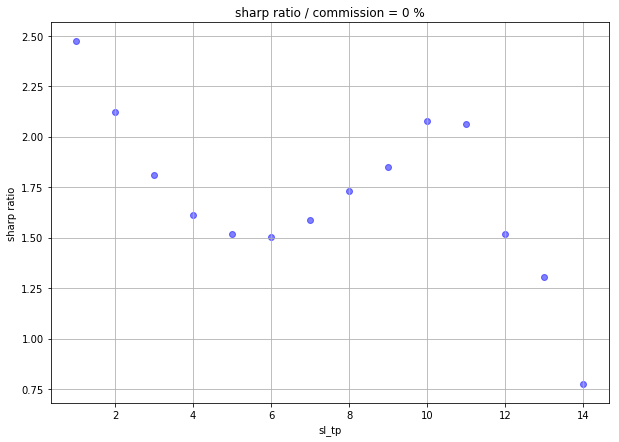

In [68]:
plt.scatter(boarder_list, [np.sum(x)/15 for x in portfolio_result_all], c="r", alpha=0.5)
plt.xlabel("sl_tp")
plt.ylabel("rub")
plt.grid()
plt.title("mean profit per contract lifetime / comission = 0 %")
plt.show()   

plt.scatter(boarder_list, [np.mean(np.cumsum(i))/np.std(np.cumsum(i)) for i in portfolio_result_all], c="b", alpha=0.5)
plt.xlabel("sl_tp")
plt.ylabel("sharp ratio")
plt.grid()
plt.title("sharp ratio / commission = 0 %")
plt.show()   


Видим, что максимальный профит дает уровень риска = 3 пунктам. Это достаточно грубая оценка, поскольку цена контракта менялась  на несколько сот процентов за 4 года. На первом графике правильно использовать долю от цены контракта, но минимальное движение ограничено спецификацией контракта.

Давайте построим график изменения стоимости портфеля в процентах. Пусть мы играем 1 контрактом. В первой половине 2015 года фьючерс сбера стоил примерно 8000р. При этом уровень риска = 3 пунктам соглаcно положению максимума на предыдущих графиках.

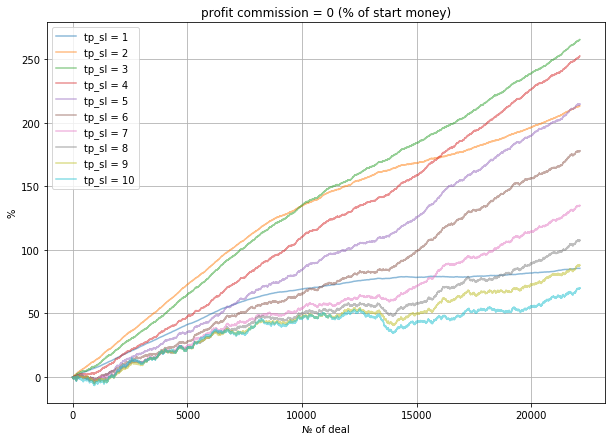

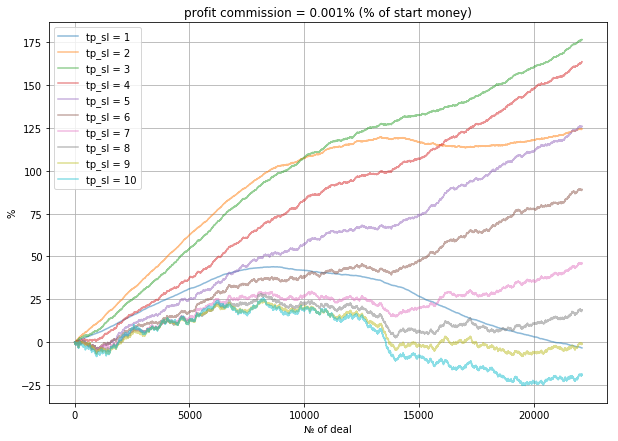

In [69]:
# изобразим изменение портфеля для разных уровней риска sl=tp (от 1 до 10 пунктов) от номера сделки
comission_payment = [i * 0.00001 for i in volume_of_operations]
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 7

for i in range(10):
    plt.plot(list(range(len(portfolio_result_all[0]))), (np.cumsum(portfolio_result_all[i]))*100/8000, label=('tp_sl = {}'.format(i+1)), alpha=0.5)
plt.xlabel("№ of deal")
plt.ylabel("%")
plt.grid()
plt.legend()
plt.title("profit commission = 0 (% of start money)")
plt.show()   


for i in range(10):
    plt.plot(list(range(len(portfolio_result_all[0]))), ((np.cumsum(portfolio_result_all[i]) - np.cumsum(comission_payment)))*100/8000, label=('tp_sl = {}'.format(i+1)), alpha=0.5)
plt.rcParams["figure.figsize"] = fig_size
plt.xlabel("№ of deal")
plt.ylabel("%")
plt.grid()
plt.legend()
plt.title("profit commission = 0.001% (% of start money)")
plt.show()   

На первых 2 линиях отчетливо видно, как плавно стратегия начинает деградировать в середине интервала. Сигнал зависит от 2 основных величин, каждая из которых в коде выражена как const*current price. Я уверен, что эти 2 константы критичны, их нужно подбирать и зависимоть может быть не линейной! В этой работе я выбрал их по своей интуиции.

Теперь нам нужно убедиться, что точки входа выбраны не просто так. Для этого оценим влияние смещения точек входа в будущее (смещать в прошлое некорректно, поскольку это нарушает элементарную логику) при том же самом размере окна.
но для проверки себя сместим на 1 тик в прошлое. должны увидеть значение < 0.5 

In [178]:
grade_list_biased_all = []
future_window = 20
bias_list = [-1, 0, 1, 2, 5]
for bias in bias_list:
    grade_list_biased = []
    for trend_file in sorted_directory_list:
        trend_data = pd.read_csv(trends_directory + trend_file, header= 0, error_bad_lines=False)
        cols = trend_data.columns
        type_of_line = trend_data[cols[0]]# 1 - сопротивление, 2 - поддержка
        start = trend_data[cols[1]]
        end = trend_data[cols[2]]
        corresponding_tick_file_name = history_directory + 'pureSBER' + \
                                       trend_file.split('trends_outofdublers_TPV_')[1]
        tick_data = pd.read_csv(corresponding_tick_file_name, sep = ',',  \
                                names=colnames, header = 0)

        y_column = tick_data['<PRICE>']
        y_column = list(y_column)
        ticks_total = len(y_column) - 1 
        x_list = list(range(len(y_column))) 

        for i, j, direction in zip(start, end, type_of_line):
            j_ = j + bias
            if j_ > ticks_total:
                j_ = ticks_total
                
            start_price = price(j_)
            future_window_end = j_ + future_window
            if future_window_end > ticks_total:
                future_window_end = ticks_total
            y_list = [(x - start_price) for x in y_column[j_:future_window_end+ bias]]
            pattern_grade = evaluete_1d_list(y_list, direction)             
            grade_list_biased.append(pattern_grade)        
        # удалим примеры, где цена осталась без единого изменения во всем окне
        grade_list_biased = list(filter(lambda a: a != -1, grade_list_biased))
    grade_list_biased_all.append(grade_list_biased)    

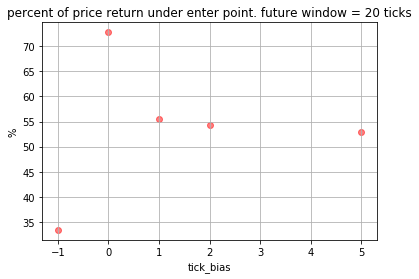

In [179]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 4

plt.scatter(bias_list, [100* np.mean(x) for x in grade_list_biased_all], c="r", alpha=0.5)
plt.xlabel("tick_bias")
plt.ylabel("%")
plt.grid()
plt.title("percent of cases where price returns under enter point. future window = 20 ticks")
plt.show()

То есть даже незначительное смещение приводит к катастрофическому исчезновению диспропорции классов. Это означает, что момент входа нетолерантен к запаздываниям.

Теперь нужно продемонстрировать то, как в среднем за всю историю наблюдений будет меняться соотношение классов при изменении ширины окна в будущее (при игнорировании случая, когда цена остается без движения).

In [180]:
grade_list_alltime = []
no_move_alltime = []
p_value_per_future_window = []
conf_int_boarders = []
for future_window in range(10,211,10):
    grade_list = []
    for trend_file in sorted_directory_list:
        trend_data = pd.read_csv(trends_directory + trend_file, header= 0, error_bad_lines=False)
        cols = trend_data.columns
        type_of_line = trend_data[cols[0]]# 1 - сопротивление, 2 - поддержка
        start = trend_data[cols[1]]
        end = trend_data[cols[2]]
        corresponding_tick_file_name = history_directory + 'pureSBER' + \
                                       trend_file.split('trends_outofdublers_TPV_')[1]
        tick_data = pd.read_csv(corresponding_tick_file_name, sep = ',',  \
                                names=colnames, header = 0)

        y_column = tick_data['<PRICE>']
        y_column = list(y_column)
        ticks_total = len(y_column) - 1 
        x_list = list(range(len(y_column)))

        for i, j, direction in zip(start, end, type_of_line):
            start_price = price(j)
            future_window_end = j + future_window
            if future_window_end > ticks_total:
                future_window_end = ticks_total
            y_list = [(x - start_price) for x in y_column[j:future_window_end]]
            pattern_grade = evaluete_1d_list(y_list, direction)             
            grade_list.append(pattern_grade)        
            
    only_move_grade_list = list(filter(lambda a: a != -1, grade_list))# удалим примеры, где цена осталась без единого изменения во всем окне
    
    no_move_alltime.append(len(list(filter(lambda a: a == -1, grade_list)))/len(grade_list))# доля примеров, где цена осталась без изменения во всем окне
    grade_list_alltime.append(np.mean(only_move_grade_list))    
    p_value_per_future_window.append(binom_test(sum(only_move_grade_list), len(only_move_grade_list), p=0.5, alternative='two-sided'))
    conf_int_boarders.append(proportion_confint(sum(only_move_grade_list), len(only_move_grade_list), method = 'wilson'))

In [181]:
future_window_list = [0]
for i,j,k, g in zip(grade_list_alltime, no_move_alltime, p_value_per_future_window, conf_int_boarders):
    future_window_list.append(future_window_list[-1]+10)
    #print('step_to_future = {}'.format(future_window_list[-1]), 'mean = {0:.3g}'.format(i), 'percent_no_move = {0:.5g}'.format(j), 'p_val = {0:.1g}'.format(k), 'conf_int', g)
future_window_list = future_window_list[1:]

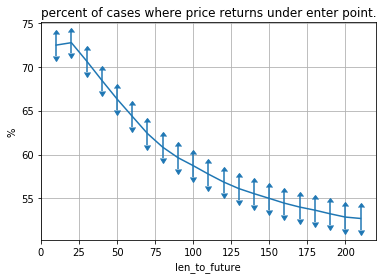

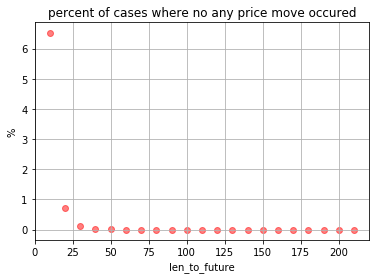

In [192]:
yerr = [100*(x[1] - x[0]) for x in conf_int_boarders] # дов инт
plt.errorbar(future_window_list, [100*x for x in grade_list_alltime], yerr = yerr, uplims=[x[1] for x in conf_int_boarders], lolims=[x[0] for x in conf_int_boarders], label='subsets of uplims and lolims')
plt.xlabel("len_to_future")
plt.ylabel("%")
plt.grid()
plt.title("percent of cases where price returns under enter point.")
plt.show()
####################################################################
plt.scatter(future_window_list, [100*x for x in no_move_alltime], c="r", alpha=0.5)
plt.xlabel("len_to_future")
plt.ylabel("%")
plt.grid()
plt.title("percent of cases where no any price move occured")
plt.show()


При величине окна >210 тиков предсказательная сила теряется, ошибка первого рода непозволительно высока, распределение классов стремится к 50/50.

## Теперь проверим, сможет ли фьючерс на ртс продемонстрировать то же поведение?
Будем рассматривать данные от 1 контракта (3 месяца). (на большее количество не хватило терпения все считать)

In [2]:
history_directory = 'C:\\Users\\user_PC\\Desktop\\rts\\pureRTS18.csv'
trends_directory = 'C:\\Users\\user_PC\\Desktop\\rts\\trends_outofdublers_TPV.csv'
colnames = ['<TIME>', '<VOLUME>', '<PRICE>']

grade_list = []
future_window = 50

trend_data = pd.read_csv(trends_directory, header= 0, error_bad_lines=False)
cols = trend_data.columns
type_of_line = trend_data[cols[0]]# 1 - сопротивление, 2 - поддержка
start = trend_data[cols[1]]
end = trend_data[cols[2]]

tick_data = pd.read_csv(history_directory, sep = ',', names=colnames, header = 0)

y_column = tick_data['<PRICE>']
y_column = list(y_column)
ticks_total = len(y_column) - 1 
x_list = list(range(len(y_column)))
   
grade_list_one_contract  = []  
for i, j, direction in zip(start, end, type_of_line):
    start_price = price(j)
    future_window_end = j + future_window
    if future_window_end > ticks_total:
        future_window_end = ticks_total
    y_list = [(x - start_price) for x in y_column[j:future_window_end]]
    pattern_grade = evaluete_1d_list(y_list, direction)        
    grade_list_one_contract.append(pattern_grade)        
# удалим примеры, где цена осталась без единого изменения во всем окне    
grade_list_one_contract = list(filter(lambda a: a != -1, grade_list_one_contract))
grade_list.append(grade_list_one_contract)    

In [33]:
for name, x in zip(sorted_directory_list, grade_list):
    print('средняя оценка в контракте RTS 2018' + ' = {0:.3g}'.format(np.mean(x)) + '     количество сигналов = {}'.format(len(x)))

средняя оценка в контракте RTS 2018 = 0.763     количество сигналов = 1928


In [34]:
for name, x in zip(sorted_directory_list, grade_list):
    print('p_value для контракта RTS 2018'.format(name.split('TPV')[1][1:-4]) + ' = ' + str(binom_test(sum(x), len(x), p=0.5, alternative='two-sided')))


p_value для контракта RTS 2018 = 2.7788251509171845e-124


In [3]:
portfolio_result_all = []
future_window = 100000# возьмем с запасом, чтобы наверняка выйти из позиции
boarder_list = list(range(10, 80, 5))
for boarder in boarder_list:   
    
    trend_data = pd.read_csv(trends_directory, header= 0, error_bad_lines=False)
    cols = trend_data.columns
    type_of_line = trend_data[cols[0]]# 1 - сопротивление, 2 - поддержка
    start = trend_data[cols[1]]
    end = trend_data[cols[2]]

    tick_data = pd.read_csv(history_directory, sep = ',', names=colnames, header = 0)
    y_column = tick_data['<PRICE>']
    y_column = list(y_column)
    ticks_total = len(y_column) - 1 
    x_list = list(range(len(y_column)))

    deal_list  = []  
    for i, j, direction in zip(start, end, type_of_line):
        start_price = price(j)
        future_window_end = j + future_window
        if future_window_end > ticks_total:
            future_window_end = ticks_total
        y_list = [(x - start_price) for x in y_column[j:future_window_end]]
        up = boarder
        down = -boarder
        deal_grade = calc_result_of_deal(y_list, direction, up, down, 0)   
        deal_list.append(deal_grade)        
# собираем список из списков returns    
    portfolio_result_all.append(deal_list)       

In [4]:
print('без комиссии')
risk = 5
for i in portfolio_result_all:
    risk += 5    
    print('risk = {}'.format(risk) + '    sharp_ratio = {}'.format(np.mean(np.cumsum(i))/np.std(np.cumsum(i))) + '   профит за 3 месяца (пп) = {0:.5g}'.format(np.sum(i)))

без комиссии
risk = 10    sharp_ratio = 1.7737149648197457   профит за 3 месяца (пп) = 11400
risk = 15    sharp_ratio = 1.75695312016901   профит за 3 месяца (пп) = 12840
risk = 20    sharp_ratio = 1.7411600951332207   профит за 3 месяца (пп) = 15480
risk = 25    sharp_ratio = 1.4960571098192694   профит за 3 месяца (пп) = 10150
risk = 30    sharp_ratio = 1.4197698816721913   профит за 3 месяца (пп) = 10860
risk = 35    sharp_ratio = 1.3529215109739774   профит за 3 месяца (пп) = 7630
risk = 40    sharp_ratio = 1.3815751390175406   профит за 3 месяца (пп) = 8080
risk = 45    sharp_ratio = 1.4120148155143306   профит за 3 месяца (пп) = 8460
risk = 50    sharp_ratio = 1.3550351912888337   профит за 3 месяца (пп) = 9100
risk = 55    sharp_ratio = 1.5042734742838098   профит за 3 месяца (пп) = 9130
risk = 60    sharp_ratio = 1.479648989654213   профит за 3 месяца (пп) = 9240
risk = 65    sharp_ratio = 1.5565055111367252   профит за 3 месяца (пп) = 11570
risk = 70    sharp_ratio = 1.6725452

In [5]:
volume_of_operations = [] 
trend_data = pd.read_csv(trends_directory, header= 0, error_bad_lines=False)
cols = trend_data.columns
type_of_line = trend_data[cols[0]]# 1 - сопротивление, 2 - поддержка
start = trend_data[cols[1]]
end = trend_data[cols[2]]

tick_data = pd.read_csv(history_directory, sep = ',', names=colnames, header = 0)
y_column = tick_data['<PRICE>']
y_column = list(y_column)
ticks_total = len(y_column) - 1 
x_list = list(range(len(y_column)))
  
for i, j, direction in zip(start, end, type_of_line):
    start_price = price(j)
    volume_of_operations.append(2*start_price)               

In [6]:
comision_coeff_list = [x/500000 for x in range (0, 14, 1)]
result_sharp = []
result_mean_profit_per_contract = []
for comision_coeff in comision_coeff_list:
    risk = 0
    comission_payment = [i * comision_coeff for i in volume_of_operations]
    _sharp = []
    _profit_per_contract = []
    result_risk = []
    for i in zip(portfolio_result_all):
        risk += 1
        result_risk += [risk]
        _profit_per_contract += [(np.sum(i) - np.sum(comission_payment))]
        _sharp += [np.mean(np.cumsum(i) - np.cumsum(comission_payment))/np.std(np.cumsum(i))]
    result_sharp += [_sharp]   
    result_mean_profit_per_contract += [_profit_per_contract]  

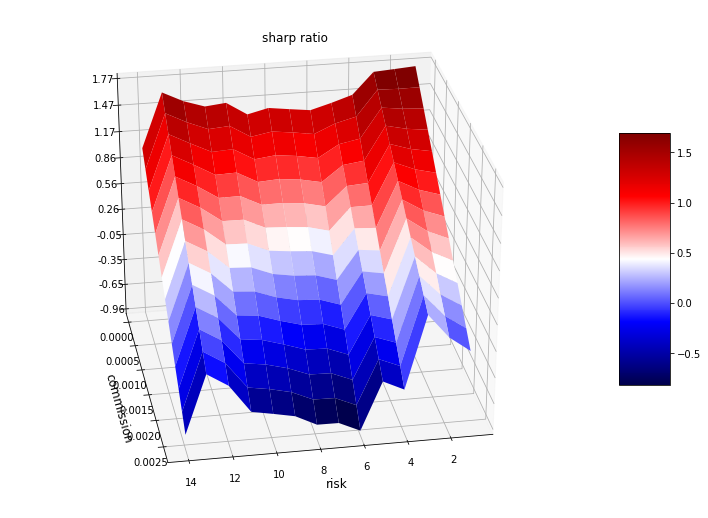

In [9]:
plot_3d(result_risk, result_sharp, 'sharp ratio', 80, 30)

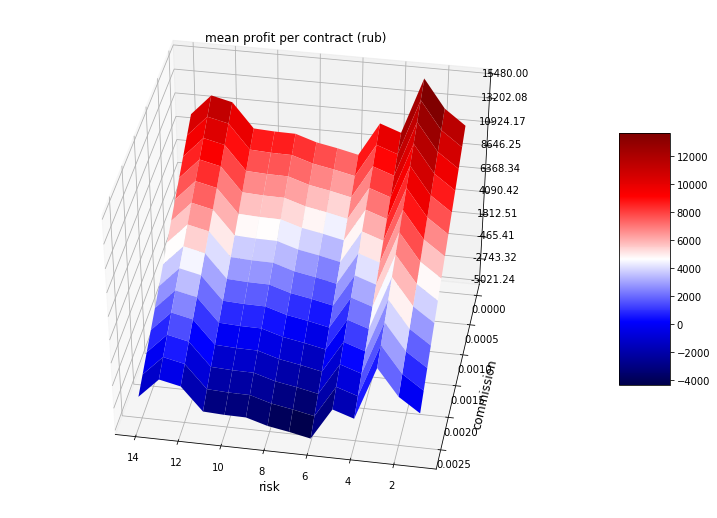

In [10]:
plot_3d(result_risk, result_mean_profit_per_contract, 'mean profit per contract (rub)', 100, 40)

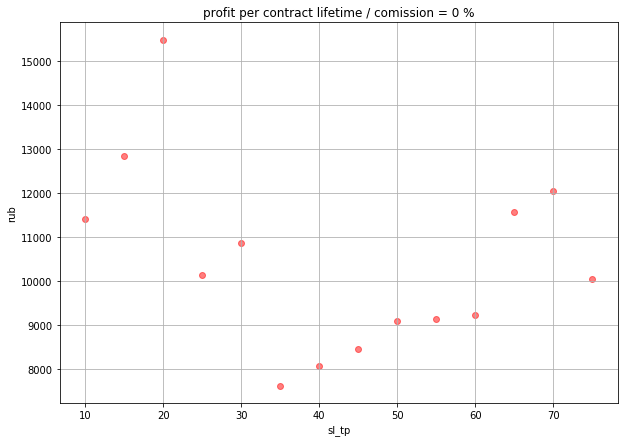

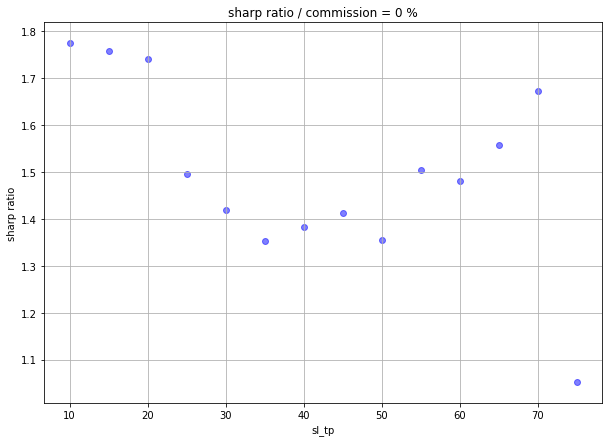

In [11]:
plt.scatter(boarder_list, [np.sum(x) for x in portfolio_result_all], c="r", alpha=0.5)
plt.xlabel("sl_tp")
plt.ylabel("rub")
plt.grid()
plt.title("profit per contract lifetime / comission = 0 %")
plt.show()   

plt.scatter(boarder_list, [np.mean(np.cumsum(i))/np.std(np.cumsum(i)) for i in portfolio_result_all], c="b", alpha=0.5)
plt.xlabel("sl_tp")
plt.ylabel("sharp ratio")
plt.grid()
plt.title("sharp ratio / commission = 0 %")
plt.show()   

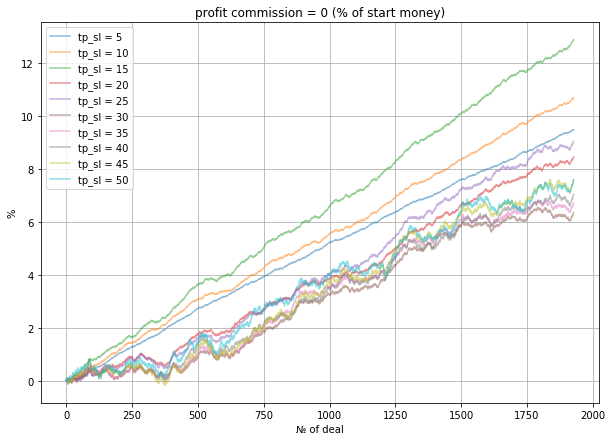

In [56]:
# изобразим изменение портфеля для разных уровней риска sl=tp (от 5 до 50 пунктов) от номера сделки
comission_payment = [i * 0.00001 for i in volume_of_operations]
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 7

for i in range(10):
    plt.plot(list(range(len(portfolio_result_all[0]))), (np.cumsum(portfolio_result_all[i]))*100/120000, label=('tp_sl = {}'.format((i+1)*5)), alpha=0.5)
plt.xlabel("№ of deal")
plt.ylabel("%")
plt.grid()
plt.legend()
plt.title("profit commission = 0 (% of start money)")
plt.show()   

In [43]:
grade_list_biased_all = []
future_window = 20
bias_list = [-1, 0, 1, 2, 5]
for bias in bias_list:
    grade_list_biased = []
    for trend_file in sorted_directory_list:
        trend_data = pd.read_csv(trends_directory, header= 0, error_bad_lines=False)
        cols = trend_data.columns
        type_of_line = trend_data[cols[0]]# 1 - сопротивление, 2 - поддержка
        start = trend_data[cols[1]]
        end = trend_data[cols[2]]

        tick_data = pd.read_csv(history_directory, sep = ',', names=colnames, header = 0)

        y_column = tick_data['<PRICE>']
        y_column = list(y_column)
        ticks_total = len(y_column) - 1 
        x_list = list(range(len(y_column))) 

        for i, j, direction in zip(start, end, type_of_line):
            j_ = j + bias
            if j_ > ticks_total:
                j_ = ticks_total
                
            start_price = price(j_)
            future_window_end = j_ + future_window
            if future_window_end > ticks_total:
                future_window_end = ticks_total
            y_list = [(x - start_price) for x in y_column[j_:future_window_end+ bias]]
            pattern_grade = evaluete_1d_list(y_list, direction)             
            grade_list_biased.append(pattern_grade)        
        # удалим примеры, где цена осталась без единого изменения во всем окне
        grade_list_biased = list(filter(lambda a: a != -1, grade_list_biased))
    grade_list_biased_all.append(grade_list_biased)    

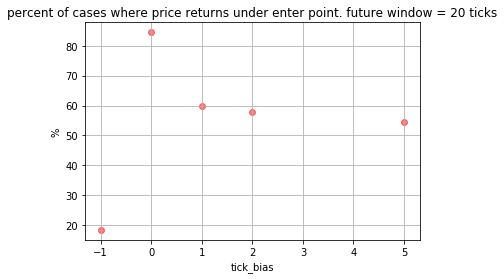

In [44]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 4

plt.scatter(bias_list, [100* np.mean(x) for x in grade_list_biased_all], c="r", alpha=0.5)
plt.xlabel("tick_bias")
plt.ylabel("%")
plt.grid()
plt.title("percent of cases where price returns under enter point. future window = 20 ticks")
plt.show()

In [45]:
grade_list_alltime = []
no_move_alltime = []
p_value_per_future_window = []
conf_int_boarders = []
for future_window in range(10,211,10):
    grade_list = []
    for trend_file in sorted_directory_list:
        trend_data = pd.read_csv(trends_directory, header= 0, error_bad_lines=False)
        cols = trend_data.columns
        type_of_line = trend_data[cols[0]]# 1 - сопротивление, 2 - поддержка
        start = trend_data[cols[1]]
        end = trend_data[cols[2]]

        tick_data = pd.read_csv(history_directory, sep = ',', names=colnames, header = 0)

        y_column = tick_data['<PRICE>']
        y_column = list(y_column)
        ticks_total = len(y_column) - 1 
        x_list = list(range(len(y_column)))

        for i, j, direction in zip(start, end, type_of_line):
            start_price = price(j)
            future_window_end = j + future_window
            if future_window_end > ticks_total:
                future_window_end = ticks_total
            y_list = [(x - start_price) for x in y_column[j:future_window_end]]
            pattern_grade = evaluete_1d_list(y_list, direction)             
            grade_list.append(pattern_grade)        
            
    only_move_grade_list = list(filter(lambda a: a != -1, grade_list))# удалим примеры, где цена осталась без единого изменения во всем окне
    
    no_move_alltime.append(len(list(filter(lambda a: a == -1, grade_list)))/len(grade_list))# доля примеров, где цена осталась без изменения во всем окне
    grade_list_alltime.append(np.mean(only_move_grade_list))    
    p_value_per_future_window.append(binom_test(sum(only_move_grade_list), len(only_move_grade_list), p=0.5, alternative='two-sided'))
    conf_int_boarders.append(proportion_confint(sum(only_move_grade_list), len(only_move_grade_list), method = 'wilson'))

In [46]:
future_window_list = [0]
for i,j,k, g in zip(grade_list_alltime, no_move_alltime, p_value_per_future_window, conf_int_boarders):
    future_window_list.append(future_window_list[-1]+10)
    #print('step_to_future = {}'.format(future_window_list[-1]), 'mean = {0:.3g}'.format(i), 'percent_no_move = {0:.5g}'.format(j), 'p_val = {0:.1g}'.format(k), 'conf_int', g)
future_window_list = future_window_list[1:]

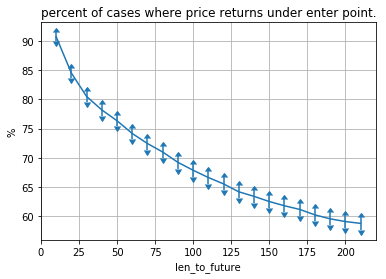

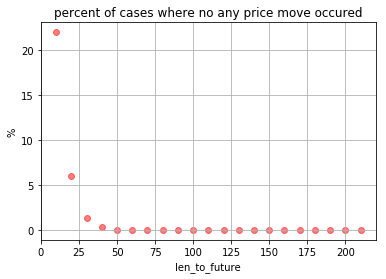

In [47]:
yerr = [100*(x[1] - x[0]) for x in conf_int_boarders] # дов инт
plt.errorbar(future_window_list, [100*x for x in grade_list_alltime], yerr = yerr, uplims=[x[1] for x in conf_int_boarders], lolims=[x[0] for x in conf_int_boarders], label='subsets of uplims and lolims')
plt.xlabel("len_to_future")
plt.ylabel("%")
plt.grid()
plt.title("percent of cases where price returns under enter point.")
plt.show()
####################################################################
plt.scatter(future_window_list, [100*x for x in no_move_alltime], c="r", alpha=0.5)
plt.xlabel("len_to_future")
plt.ylabel("%")
plt.grid()
plt.title("percent of cases where no any price move occured")
plt.show()